# Context

After training the model from scratch, we decided it would be better to train a separate model for each phylum. We also opted to use pretrained models. In this notebook, we aim to identify the best-performing pretrained model.

- We compare the models based on their performance on the majority class phylum.
- The same preprocessing steps and model pipeline were used for each model to ensure a fair comparison.


# Imports

In [1]:
from google.colab import drive
import zipfile
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/rare_species 1.zip'
extract_path = '/content/rare_species 1'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Mounted at /content/drive


In [2]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow import data as tf_data
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2, Xception, DenseNet121
from tensorflow.keras.layers import Rescaling, RandAugment

from sklearn.metrics import classification_report

In [3]:
# With colab
folder_path = '/content/rare_species 1/rare_species 1'
meta = pd.read_csv('/content/rare_species 1/rare_species 1/metadata.csv')

# With vscode
# folder_path = '../data/rare_species 1'
# meta = pd.read_csv('../data/rare_species 1/metadata.csv')

# Splits

In [4]:

image_size = (224, 224)
seed = 42
batch_size = 32

train_ds, val_ds= keras.utils.image_dataset_from_directory(
    folder_path,
    validation_split=0.2,
    subset= "both",
    seed= seed,
    image_size= image_size,
    batch_size= batch_size
)


Found 11983 files belonging to 202 classes.
Using 9587 files for training.
Using 2396 files for validation.


# Defining the different models

In this section, we create three different models. All models are built using the same architecture to allow for fair comparison. The pipeline for each model includes the following components:

- **Augmentation layer**: Applies basic random transformations to simulate data variability.
- **Rescaling layer**: Normalizes pixel values.
- **Pretrained model**: Varies between the models to test performance differences.
- **Flatten layer**: Converts the output of the convolutional base to a 1D vector.
- **Dropout layer**: Helps the model generalize better by reducing overfitting.

Although this setup is not optimal—since different pretrained models may respond better to different image sizes and configurations—we believe this approach provides a consistent and efficient basis for comparison.

In [5]:
# Model creation functions for different architectures
def make_model_vgg16(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Rescaling layer
    x = RandAugment(value_range= (0, 255))(inputs)
    x = Rescaling(1./255)(x)

    # Pretrained VGG16 base
    base_model = VGG16(include_top=False, input_tensor=x, weights="imagenet")
    base_model.trainable = False  # Freeze for transfer learning

    x = base_model.output
    x = layers.Flatten()(x)
    x = layers.Dropout(0.1)(x)  # Optional regularization

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)

def make_model_resnet50(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Rescaling layer
    x = RandAugment(value_range= (0, 255))(inputs)
    x = Rescaling(1./255)(x)

    # Pretrained ResNet50 base
    base_model = ResNet50(include_top=False, input_tensor=x, weights="imagenet")
    base_model.trainable = False  # Freeze for transfer learning

    x = base_model.output
    x = layers.Flatten()(x)
    x = layers.Dropout(0.1)(x)  # Optional regularization

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)

def make_model_mobilenetv2(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Rescaling layer
    x = RandAugment(value_range= (0, 255))(inputs)
    x = Rescaling(1./255)(x)

    # Pretrained MobileNetV2 base
    base_model = MobileNetV2(include_top=False, input_tensor=x, weights="imagenet")
    base_model.trainable = False  # Freeze for transfer learning

    x = base_model.output
    x = layers.Flatten()(x)
    x = layers.Dropout(0.1)(x)  # Optional regularization

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)

# Train and evaluate the models

For each of the model we save only the model with the best score on val in order to compare the models. if one model as a very high val-score it doesn't mean it will be picked as other parameter like over/under-fitting, loss is taken into account

In [ ]:
def train_and_evaluate_model(model, model_name, train_ds, val_ds, epochs=50):
    """Train and evaluate a model, saving the best version"""


    # Callbacks
    checkpoint_path = f"best_model_{model_name}.keras"
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            checkpoint_path,
            save_best_only=True,
            monitor="val_acc",
            mode="max",
            verbose=1
        )
    ]

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )

    # Train the model
    history = model.fit(
        train_ds,
        epochs=epochs,
        callbacks=callbacks,
        validation_data=val_ds,
    )

    # Load the best model
    best_model = keras.models.load_model(checkpoint_path)

    # Get predictions
    y_pred_probs = best_model.predict(val_ds)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Get true labels
    y_true = np.concatenate([y for x, y in val_ds], axis=0)

    # Print classification report
    print(f"\nClassification Report for {model_name}:")
    report = classification_report(y_true, y_pred, output_dict=True)
    print(classification_report(y_true, y_pred))

    # Return metrics and paths
    return {
        'model_name': model_name,
        'history': history.history,
        'accuracy': report['accuracy'],
        'f1_macro': report['macro avg']['f1-score'],
        'f1_weighted': report['weighted avg']['f1-score'],
        'model_path': checkpoint_path
    }

# Model comparasion


In [7]:
def compare_models(results):
    """Compare results from multiple models"""

    # Create comparison DataFrame
    comparison = pd.DataFrame([
        {'Model': r['model_name'],
         'Accuracy': r['accuracy'],
         'F1 (Macro)': r['f1_macro'],
         'F1 (Weighted)': r['f1_weighted']}
        for r in results
    ])

    # Sort by accuracy
    comparison = comparison.sort_values('Accuracy', ascending=False)

    # Print results
    print(f"\n=== Model Comparison ===")
    print(comparison)

    # Create visualization
    plt.figure(figsize=(12, 6))

    # Plot accuracy comparison
    plt.subplot(1, 2, 1)
    plt.bar(comparison['Model'], comparison['Accuracy'])
    plt.title('Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)

    # Plot F1 comparison
    plt.subplot(1, 2, 2)
    plt.bar(comparison['Model'], comparison['F1 (Weighted)'])
    plt.title('F1 Score (Weighted) Comparison')
    plt.ylabel('F1 Score')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)

    plt.tight_layout()
    plt.savefig('model_comparison.png')
    plt.show()

    # Print best model
    best_model = comparison.iloc[0]
    print(f"\nBest model for: {best_model['Model']}")
    print(f"Accuracy: {best_model['Accuracy']:.4f}")
    print(f"F1 Score (Weighted): {best_model['F1 (Weighted)']:.4f}")

    return comparison

# Function to plot learning curves
def plot_learning_curves(results):
    """Plot learning curves for all models"""

    plt.figure(figsize=(12, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    for result in results:
        plt.plot(result['history']['acc'], label=f"{result['model_name']} (Train)")
        plt.plot(result['history']['val_acc'], label=f"{result['model_name']} (Val)", linestyle='--')

    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)

    # Plot loss
    plt.subplot(1, 2, 2)
    for result in results:
        plt.plot(result['history']['loss'], label=f"{result['model_name']} (Train)")
        plt.plot(result['history']['val_loss'], label=f"{result['model_name']} (Val)", linestyle='--')

    plt.title(f'Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(f'learning_curves.png')
    plt.show()

# Model run

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


<ipython-input-5-bf053a51f449>:48: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, input_tensor=x, weights="imagenet")


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

=== Training VGG16 dataset ===
Epoch 1/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - acc: 0.0885 - loss: 6.6334
Epoch 1: val_acc improved from -inf to 0.17028, saving model to best_model_vgg16.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 213s 680ms/step - acc: 0.0887 - loss: 6.6319 - val_acc: 0.1703 - val_loss: 5.7327
Epoch 2/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - acc: 0.2892 - loss: 4.2134
Epoch 2: val_acc did not improve from 0.17028
300/300 ━━━━━━━━━━━━━━━━━━━━ 247s 656ms/step - acc: 0.2892 - loss: 4.2141 - val_acc: 0.1348 - val_loss: 6.5076
Epoch 3/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - acc: 0.3510 - loss: 3.7804
Epoch 3: val_acc improved from 0.17028 to 0.17988, saving model to best_model_vgg16.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 194s 630ms/step - acc: 0.3510 - loss: 3.7807 - val_acc: 0.1799 - val_loss: 5.9729
Epoch 4/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - acc: 0.4189 - loss: 3.1907
Epoch 4: val_acc did not improv

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - acc: 0.0166 - loss: 22.7041
Epoch 1: val_acc improved from -inf to 0.01461, saving model to best_model_resnet50.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 202s 642ms/step - acc: 0.0166 - loss: 22.6903 - val_acc: 0.0146 - val_loss: 17.2545
Epoch 2/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - acc: 0.0406 - loss: 12.8526
Epoch 2: val_acc improved from 0.01461 to 0.03631, saving model to best_model_resnet50.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 193s 618ms/step - acc: 0.0406 - loss: 12.8551 - val_acc: 0.0363 - val_loss: 14.9710
Epoch 3/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - acc: 0.0535 - loss: 13.3836
Epoch 3: val_acc did not improve from 0.03631
300/300 ━━━━━━━━━━━━━━━━━━━━ 207s 634ms/step - acc: 0.0535 - loss: 13.3846 - val_acc: 0.0326 - val_loss: 13.6743
Epoch 4/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - acc: 0.0575 - loss: 13.1552
Epoch 4: val_acc improved from 0.03631 to 0.03840, saving model to best_model_resnet50.keras
300/300 ━━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - acc: 0.1914 - loss: 24.6239
Epoch 1: val_acc improved from -inf to 0.36144, saving model to best_model_mobilenetv2.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 194s 630ms/step - acc: 0.1916 - loss: 24.6277 - val_acc: 0.3614 - val_loss: 22.2718
Epoch 2/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - acc: 0.4539 - loss: 18.0544
Epoch 2: val_acc improved from 0.36144 to 0.41611, saving model to best_model_mobilenetv2.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 200s 627ms/step - acc: 0.4539 - loss: 18.0568 - val_acc: 0.4161 - val_loss: 24.1951
Epoch 3/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - acc: 0.5654 - loss: 14.3980
Epoch 3: val_acc improved from 0.41611 to 0.43364, saving model to best_model_mobilenetv2.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 200s 620ms/step - acc: 0.5654 - loss: 14.4006 - val_acc: 0.4336 - val_loss: 26.9326
Epoch 4/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - acc: 0.6130 - loss: 14.0352
Epoch 4: val_acc improved from 0.43364 to 0.44157, 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

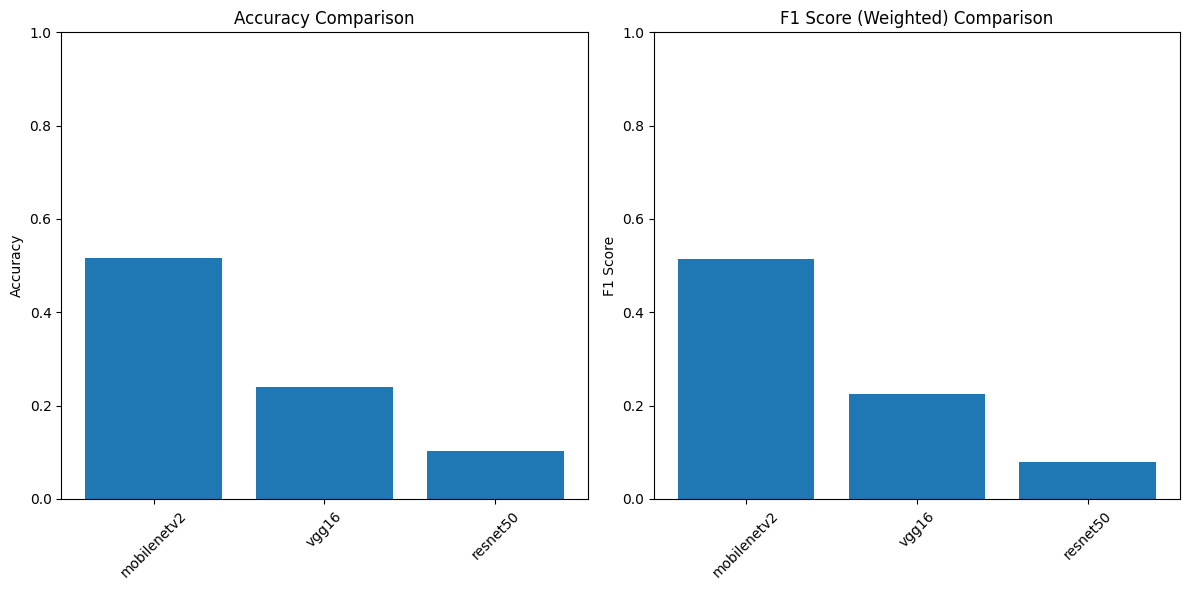


Best model for: mobilenetv2
Accuracy: 0.5154
F1 Score (Weighted): 0.5143


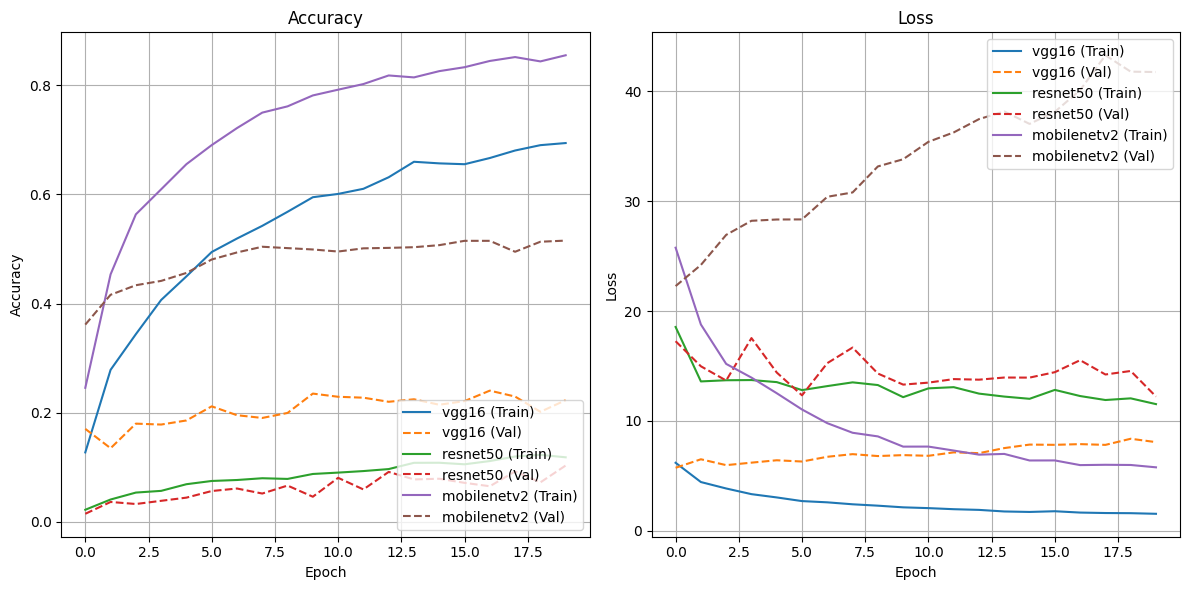

In [8]:
epochs = 20

model_vgg16 = make_model_vgg16(input_shape=image_size + (3,), num_classes=202)
model_resnet50 = make_model_resnet50(input_shape=image_size + (3,), num_classes=202)
model_mobilenet = make_model_mobilenetv2(input_shape=image_size + (3,), num_classes=202)

# Train and evaluate models
results = []

# Train VGG16
print("\n=== Training VGG16 dataset ===")
result_vgg16 = train_and_evaluate_model(
    model=model_vgg16,
    model_name="vgg16",
    train_ds=train_ds,
    val_ds=val_ds,
    epochs=epochs
)
results.append(result_vgg16)

# Train ResNet50
print("\n=== Training ResNet50 dataset ===")
result_resnet50 = train_and_evaluate_model(
    model=model_resnet50,
    model_name="resnet50",
    train_ds=train_ds,
    val_ds=val_ds,
    epochs=epochs
)
results.append(result_resnet50)

# Train MobileNetV2
print("\n=== Training MobileNetV2 dataset ===")
result_mobilenet = train_and_evaluate_model(
    model=model_mobilenet,
    model_name="mobilenetv2",
    train_ds=train_ds,
    val_ds=val_ds,
    epochs=epochs
)
results.append(result_mobilenet)

# Compare models
compare_models(results)

# Plot learning curves
plot_learning_curves(results)


# Conclusion

From the run we can conclude that the pretrain model mobilenetv2 performs better on every aspect than the other therefore it is propable that we chose this one for future step 